In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './TBrain_Round2_DataSet_20180511'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
TS_IN=10
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
5248,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
7872,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9184,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
3936,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
10496,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11808,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0
2624,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
13120,6201,20130102,元大富櫃50,9.08,9.18,9.01,9.13,254.0
14432,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28.0


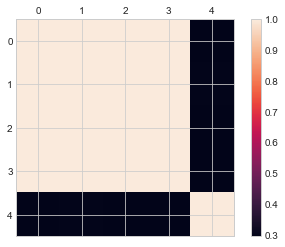

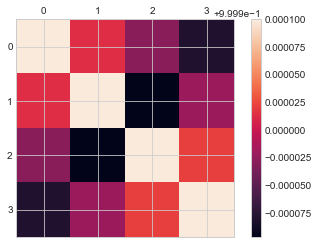

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[fields].corr())
fig.colorbar(cax)
plt.show()
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']].corr())
fig.colorbar(cax)
plt.show()

In [4]:
codes = list(sorted(set(train_csv['代碼'])))

code 50


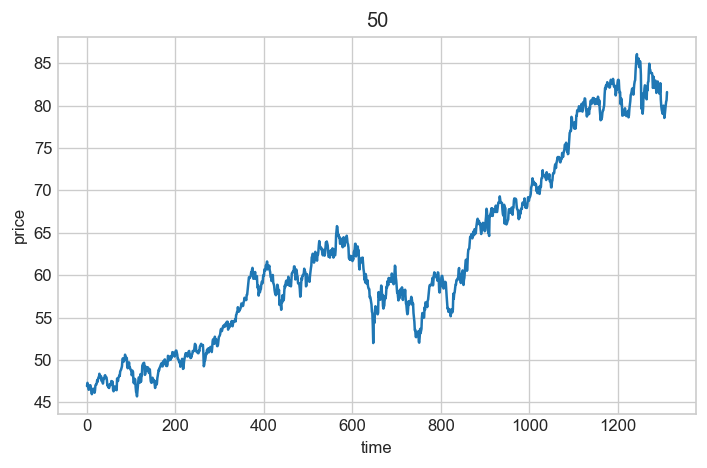

code 51


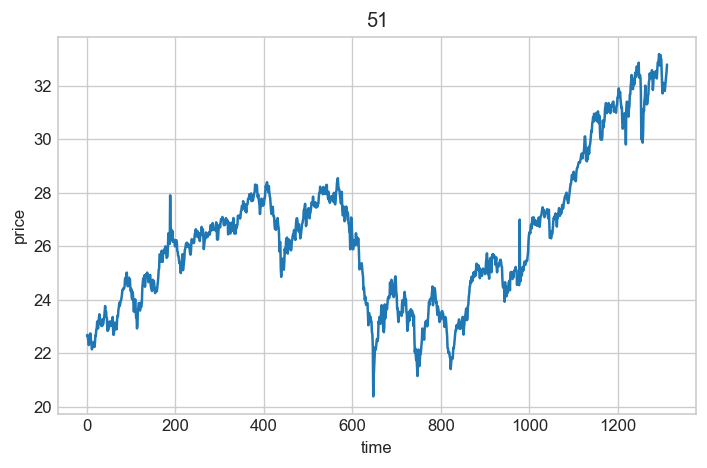

code 52


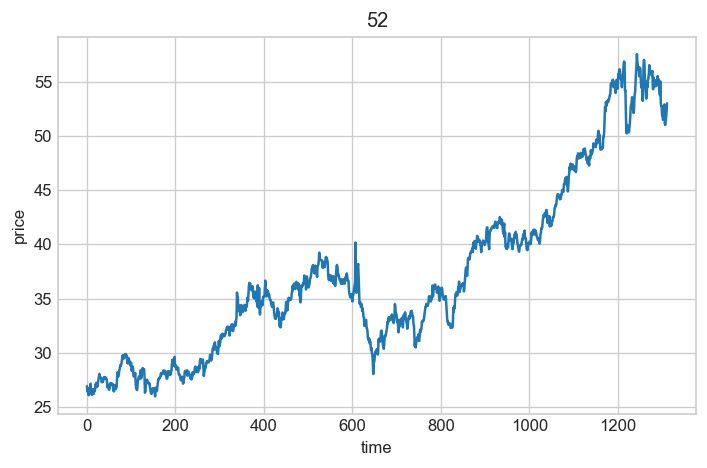

code 53


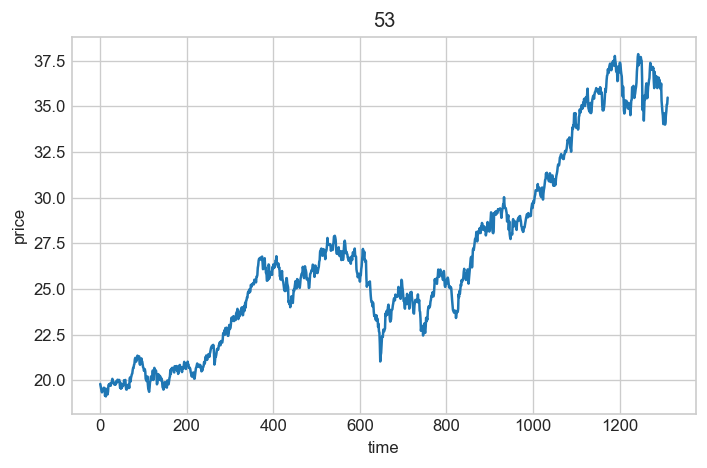

code 54


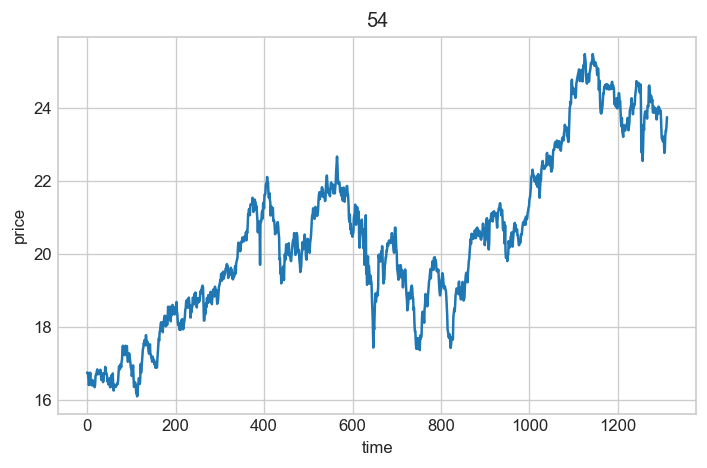

code 55


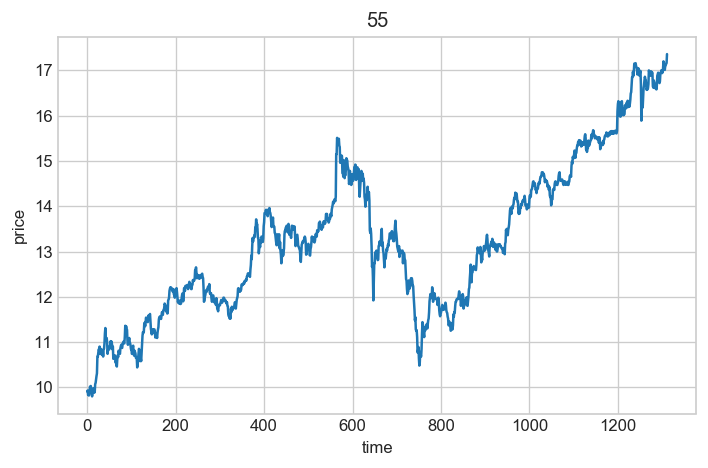

code 56


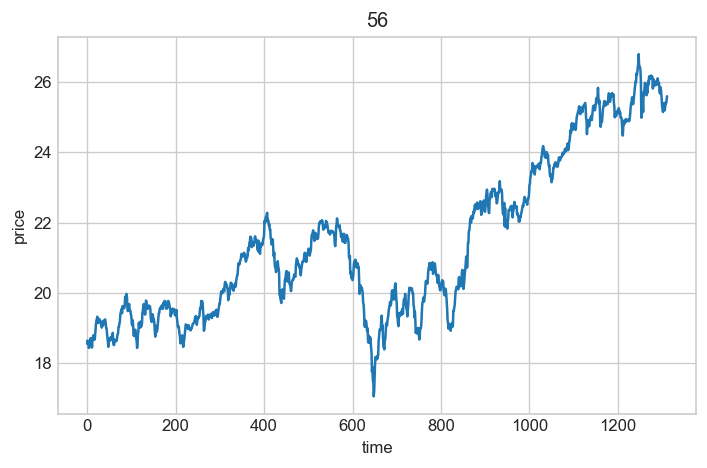

code 57


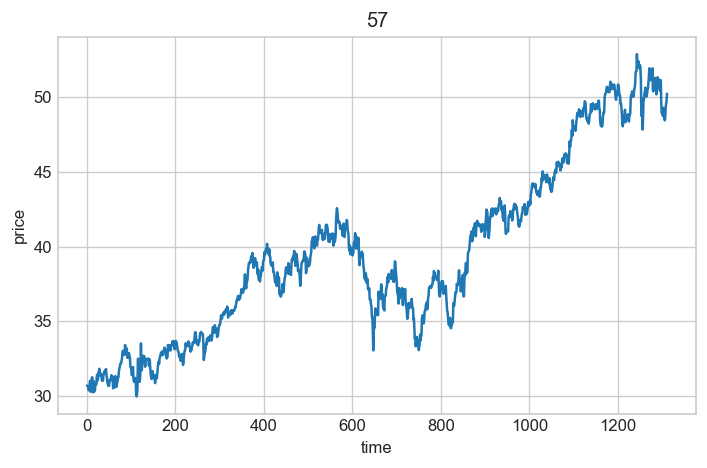

code 58


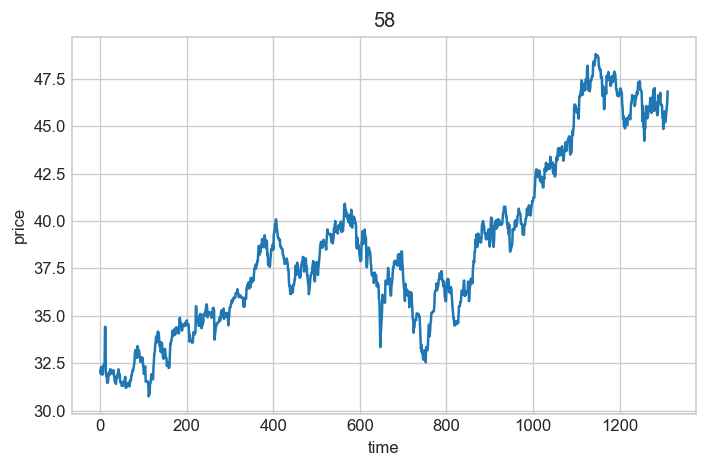

code 59


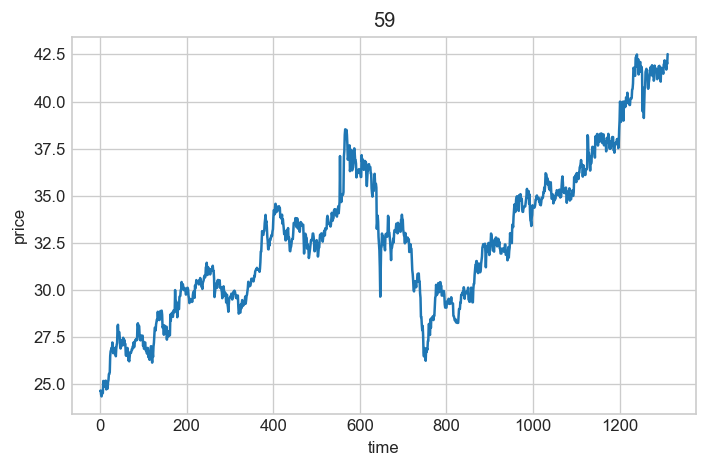

code 690


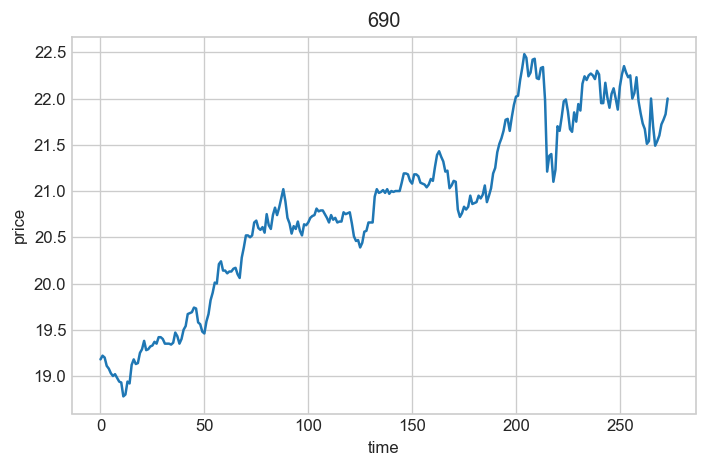

code 692


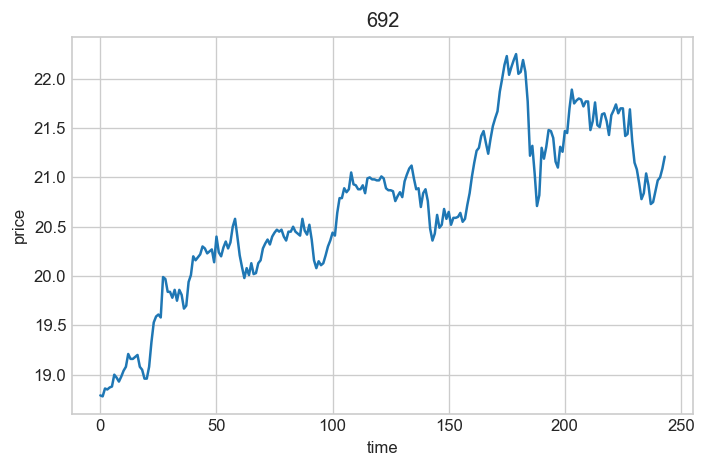

code 701


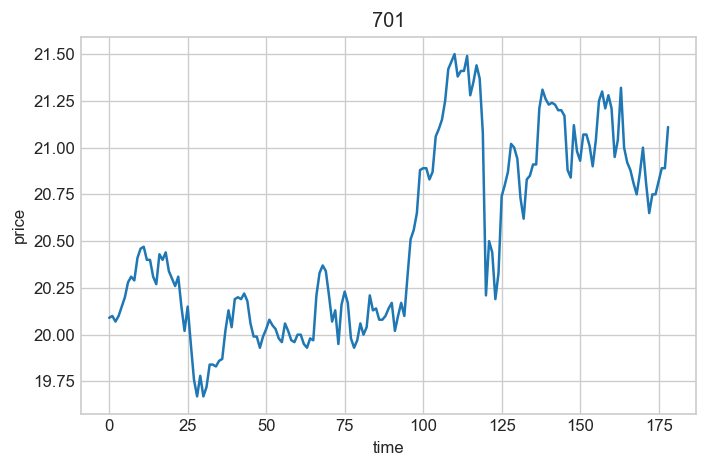

code 713


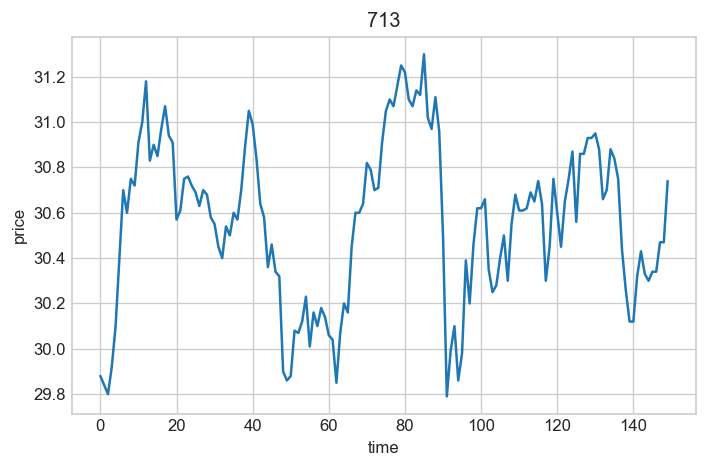

code 6201


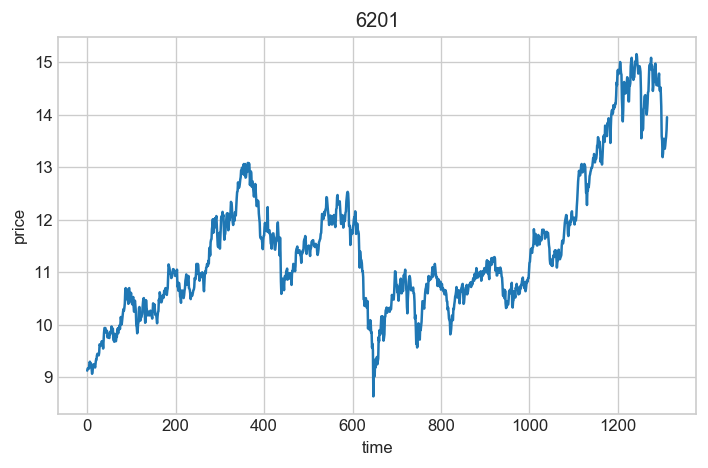

code 6203


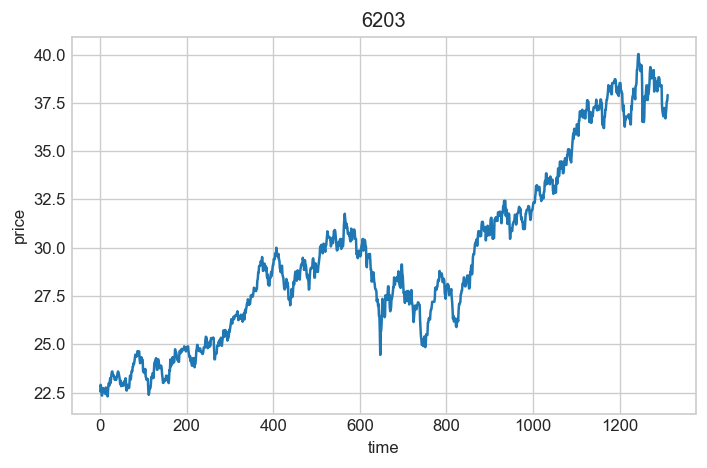

code 6204


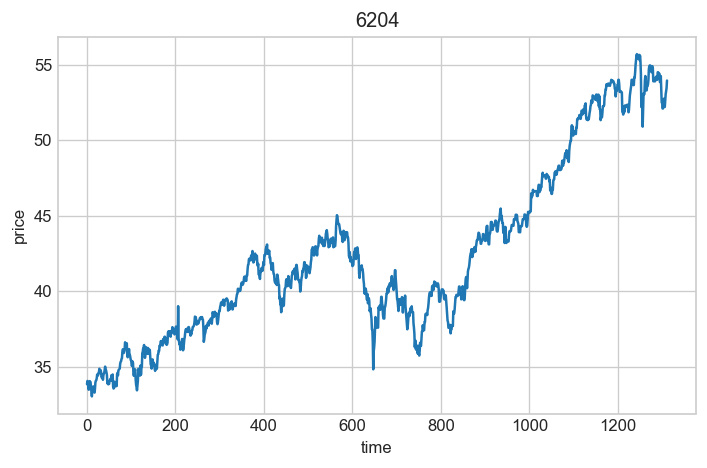

code 6208


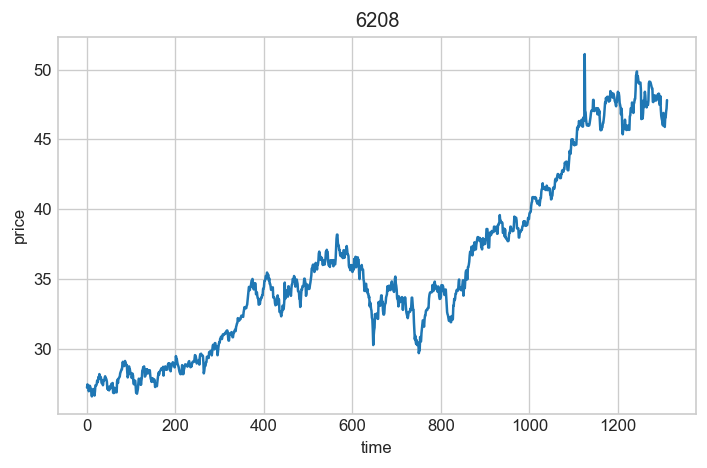

In [5]:
split_train = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)
    label = np.append(np.array([0], dtype=np.float32), (row[1:,-2] > row[:-1,-2]).astype(np.float32)).astype(np.float32)[...,np.newaxis]
    row = np.append(row, label, axis=-1)
    print('code {:d}'.format(code))
    fit, ax = plt.subplots(dpi=120)
    ax.set_title(str(code))
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    ax.plot(range(row.shape[0]), row[...,fields_dict['收盤價(元)']])
    plt.tight_layout()
    plt.show()
    split_train.append(row)

In [6]:
for n, s in enumerate(split_train):
    print(codes[n], len(s))

50 1312
51 1312
52 1312
53 1312
54 1312
55 1312
56 1312
57 1312
58 1312
59 1312
690 274
692 244
701 179
713 150
6201 1312
6203 1312
6204 1312
6208 1312


In [7]:
from keras.regularizers import *
from keras.metrics import binary_accuracy

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def classification_score(y_true, y_pred):
    return binary_accuracy(y_true, y_pred) * np.array([0.1, 0.15, 0.2, 0.25, 0.3])

def regression_score(y_true, y_pred):
    return (y_true - K.abs(y_pred-y_true)) / (y_true+K.epsilon()) * np.array([0.1, 0.15, 0.2, 0.25, 0.3])

def make_model(ts_in=60, ts_out=5, n_field=6, n_encode=128, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    lstm_1 = CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)) (input_)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4_regression     = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a)), name='regression') (lstm_4)
    fc_4_classification = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a), activation='sigmoid'), name='class') (lstm_4)
    return Model([input_], [fc_4_regression, fc_4_classification])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 6)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 128)          69632       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 128)       0           cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 5, 128)       132096      repeat_vector_1[0][0]            
__________________________________________________________________________________________________
cu_dnnlstm

In [8]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    Ys_label = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
        Ys_label.append(seq[i+ts_in:i+total_l, -1:]) # 漲跌
    return np.asarray(Xs), np.asarray(Ys), np.asarray(Ys_label)

In [9]:
train_18 = []
for seq in split_train:
    Xs, Ys, Ys_label = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys, Ys_label])

In [10]:
from matplotlib.figure import figaspect
def vis(history, title='no title', dpi=80):
    # r2, classification_score, regression_score, lb
    fig_, ax_ = plt.subplots(2, 3, dpi=80, figsize=(20, 5))
    ax = ax_.ravel()
    titles = ['mse', 'bce', 'r2', 'classification_score', 'regression_score', 'lb']
    for i, p in enumerate(titles):
        ax[i].set_title(title + ' ' + p + ' plot')
    for i in range(6):
        ax[i].set_xlabel('epoch')
    scores = ['mse', 'bce', 'r2', 'acc', 't_brain_regression', 'lb']
    for i, s in enumerate(scores):
        ax[i].set_ylabel(s)
    metric_names = ['regression_loss', 'class_loss', 'regression_r2_keras', 'class_classification_score', 'regression_regression_score']
    locs = [0, 0, 1, 1, 1]
    for i, (name, loc) in enumerate(zip(metric_names, locs)):
        ax[i].plot(history.history[name])
        ax[i].plot(history.history['val_'+name])
        ax[i].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    ax[-1].plot(0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score']))
    ax[-1].plot(0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score']))
    ax[-1].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    plt.tight_layout()
    plt.show()

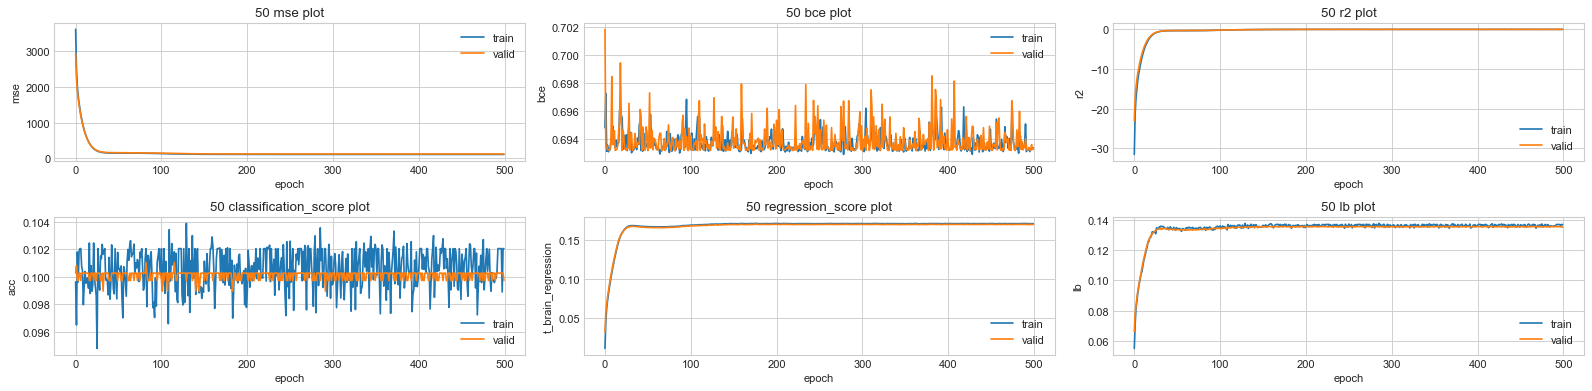

validation bce: 0.693213
validation mse: 125.057938
validation r2 : -0.018340
validation acc: 0.099731
validation regression: 0.170619
validation lb: 0.135175


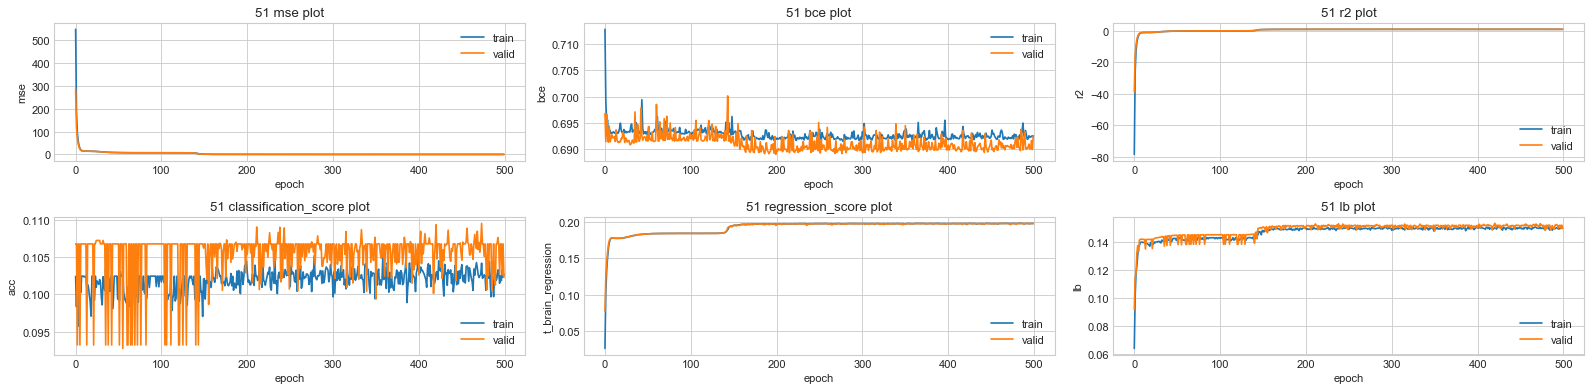

validation bce: 0.692543
validation mse: 0.253461
validation r2 : 0.964512
validation acc: 0.102269
validation regression: 0.197368
validation lb: 0.149819


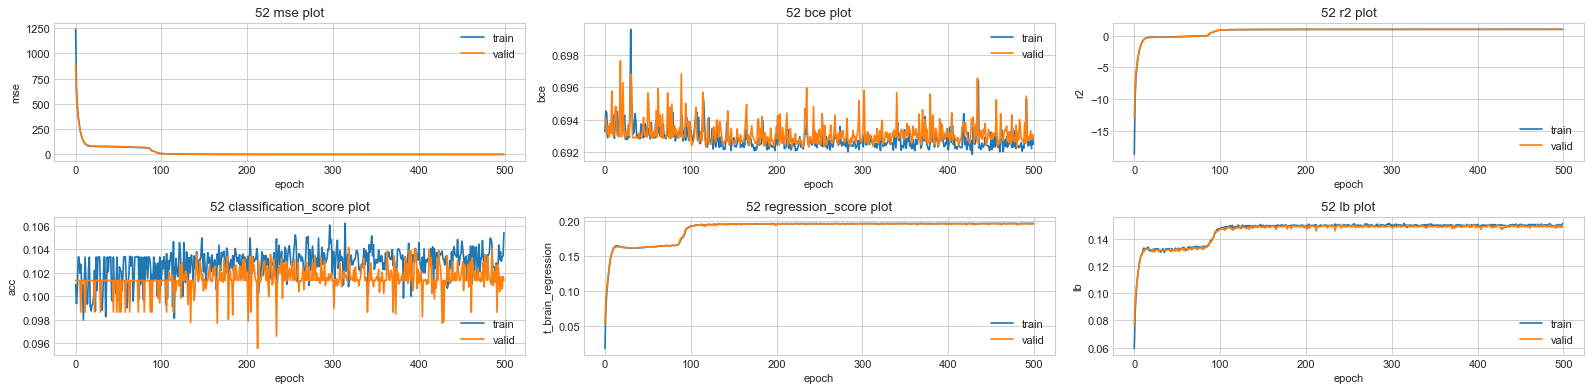

validation bce: 0.692869
validation mse: 1.185103
validation r2 : 0.982178
validation acc: 0.101346
validation regression: 0.196106
validation lb: 0.148726


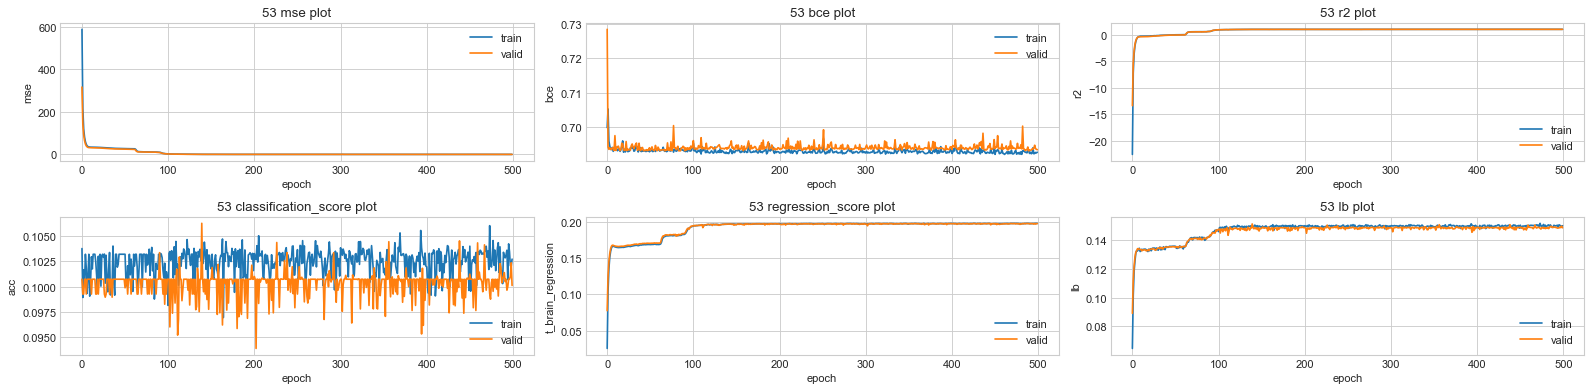

validation bce: 0.693392
validation mse: 0.288180
validation r2 : 0.987517
validation acc: 0.100115
validation regression: 0.197203
validation lb: 0.148659


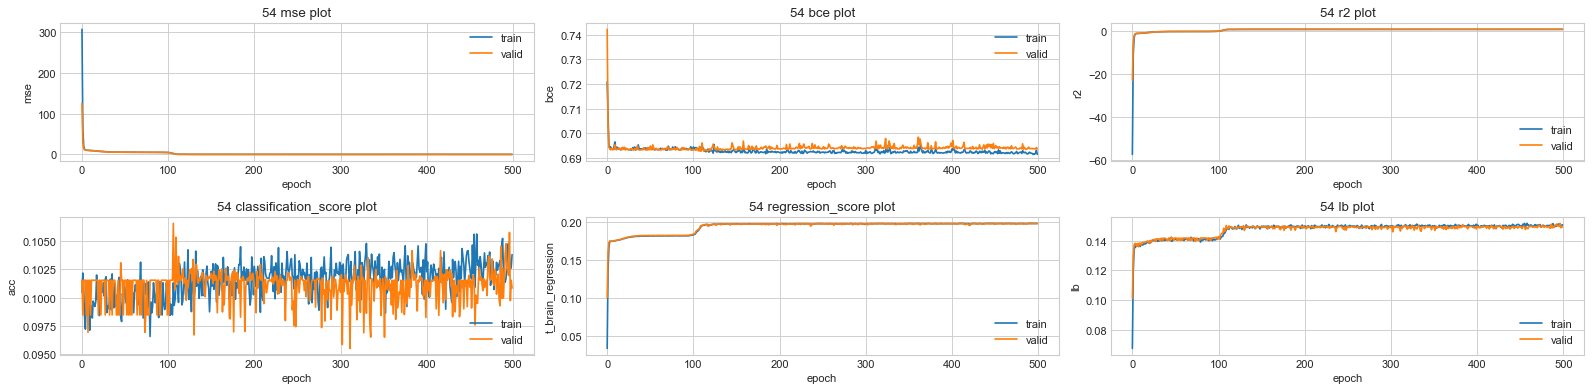

validation bce: 0.693564
validation mse: 0.145475
validation r2 : 0.972637
validation acc: 0.100846
validation regression: 0.197411
validation lb: 0.149129


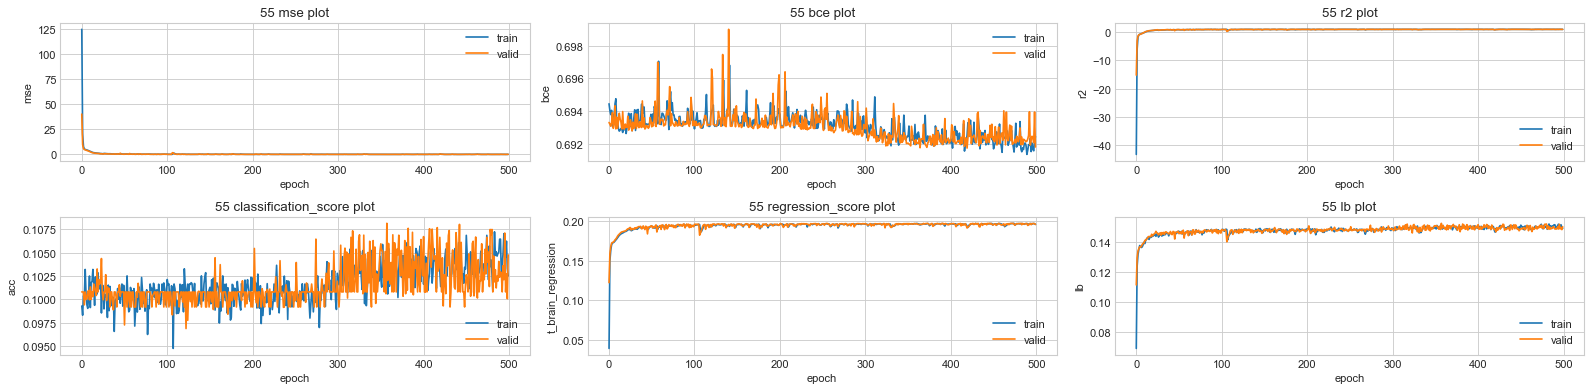

validation bce: 0.691802
validation mse: 0.135456
validation r2 : 0.945775
validation acc: 0.104769
validation regression: 0.195840
validation lb: 0.150305


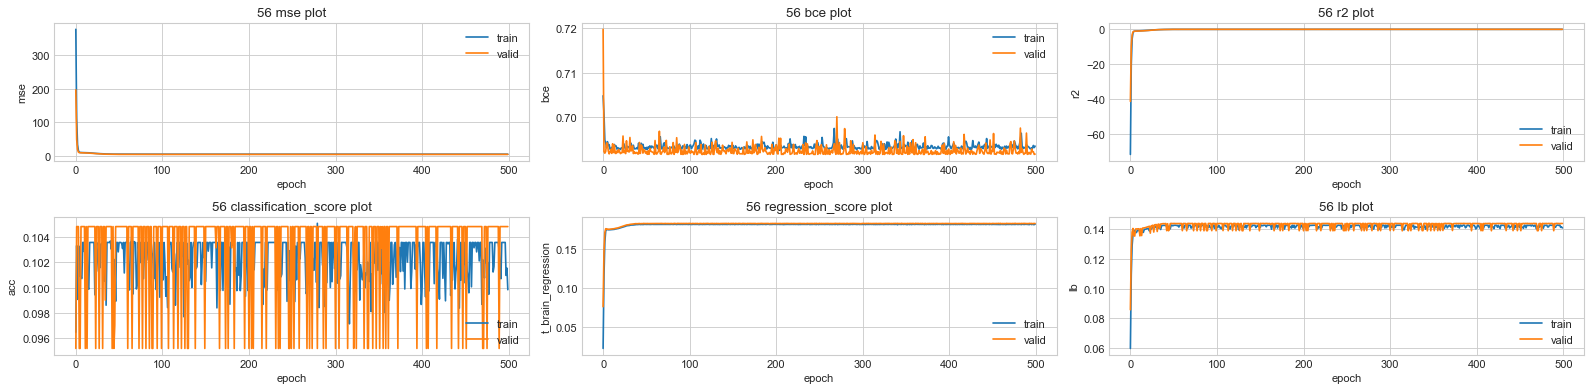

validation bce: 0.691606
validation mse: 4.681511
validation r2 : -0.008517
validation acc: 0.104846
validation regression: 0.183221
validation lb: 0.144034


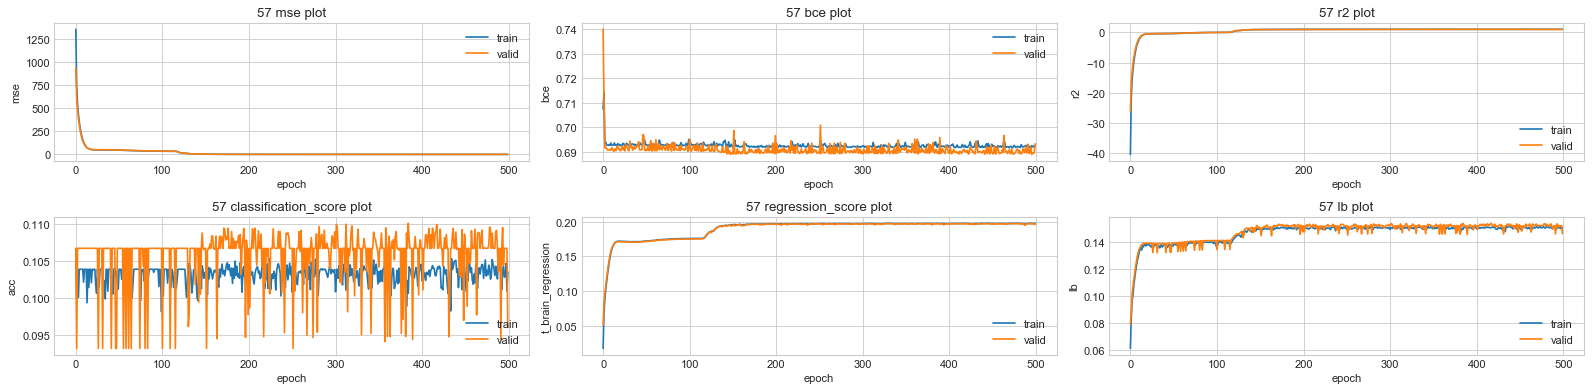

validation bce: 0.693336
validation mse: 1.041410
validation r2 : 0.970074
validation acc: 0.096077
validation regression: 0.196033
validation lb: 0.146055


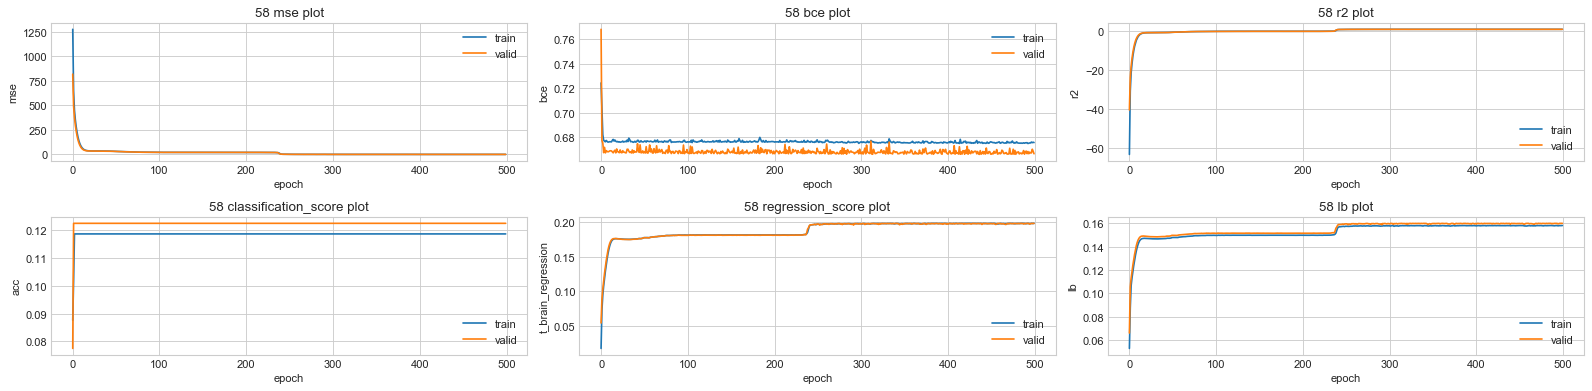

validation bce: 0.666353
validation mse: 0.479327
validation r2 : 0.976627
validation acc: 0.122500
validation regression: 0.197503
validation lb: 0.160002


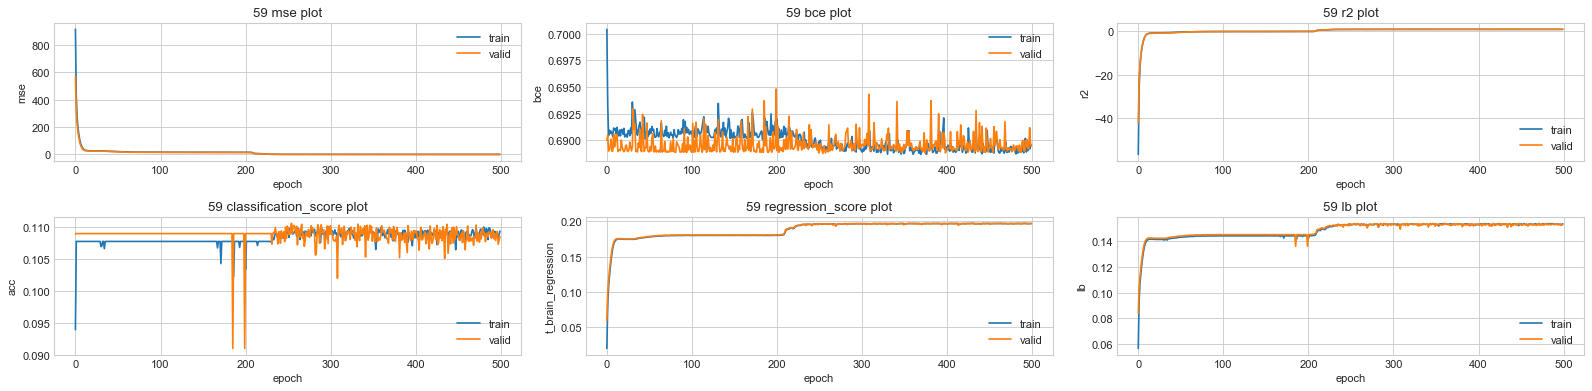

validation bce: 0.689465
validation mse: 0.468947
validation r2 : 0.965828
validation acc: 0.108577
validation regression: 0.196973
validation lb: 0.152775


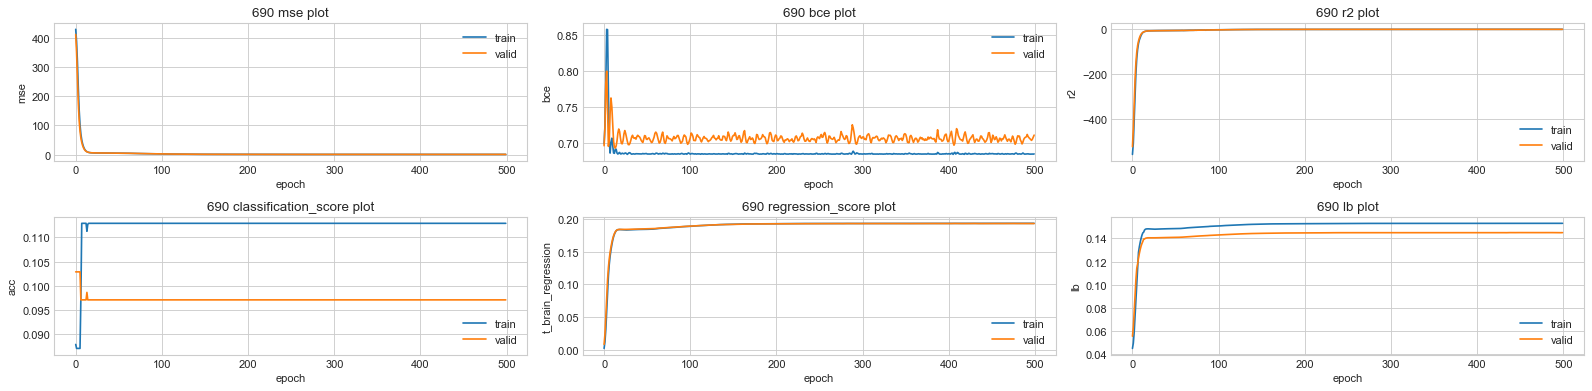

validation bce: 0.711207
validation mse: 0.858615
validation r2 : -0.097721
validation acc: 0.097115
validation regression: 0.192852
validation lb: 0.144983


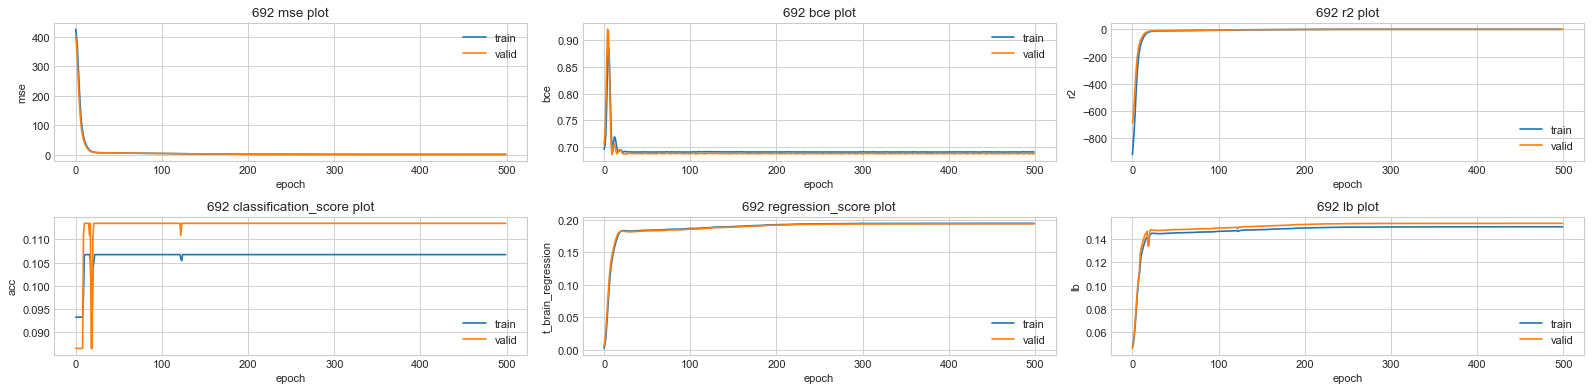

validation bce: 0.687538
validation mse: 0.623380
validation r2 : -0.068245
validation acc: 0.113478
validation regression: 0.193705
validation lb: 0.153592


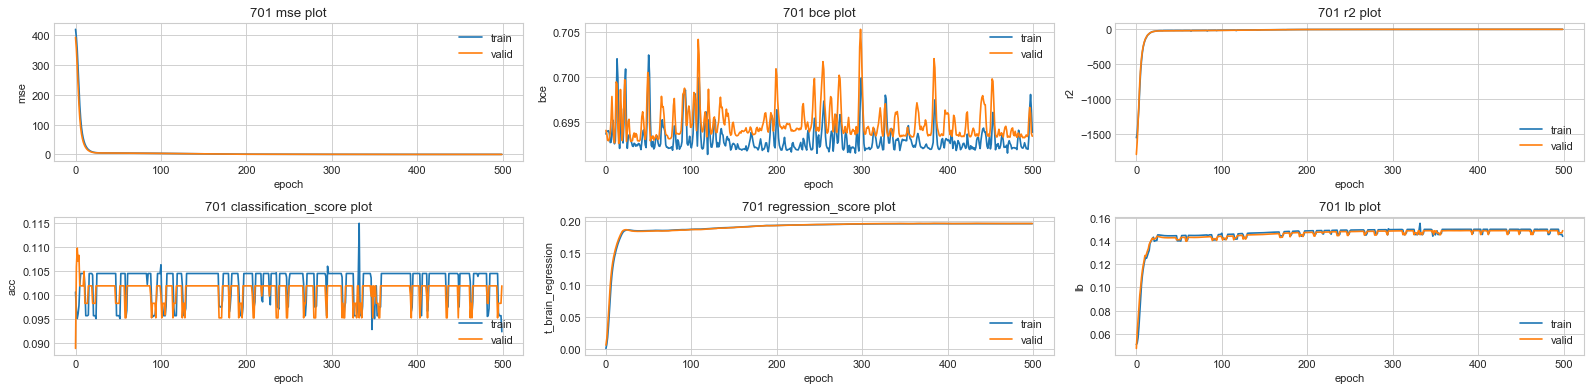

validation bce: 0.693458
validation mse: 0.247863
validation r2 : -0.137446
validation acc: 0.101818
validation regression: 0.195598
validation lb: 0.148708


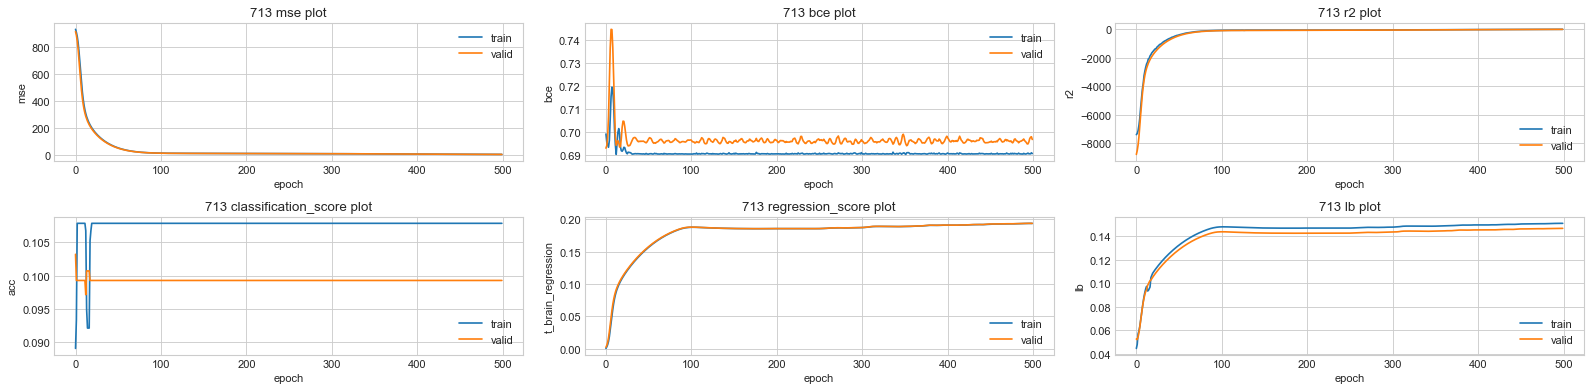

validation bce: 0.696692
validation mse: 1.845386
validation r2 : -16.767683
validation acc: 0.099286
validation regression: 0.193933
validation lb: 0.146609


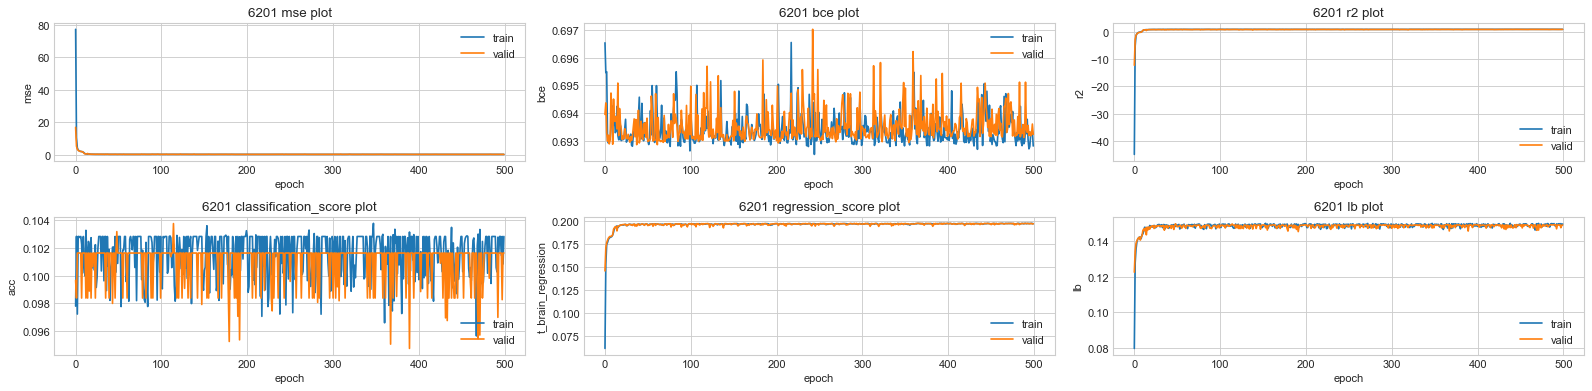

validation bce: 0.693241
validation mse: 0.079732
validation r2 : 0.934061
validation acc: 0.101615
validation regression: 0.196734
validation lb: 0.149175


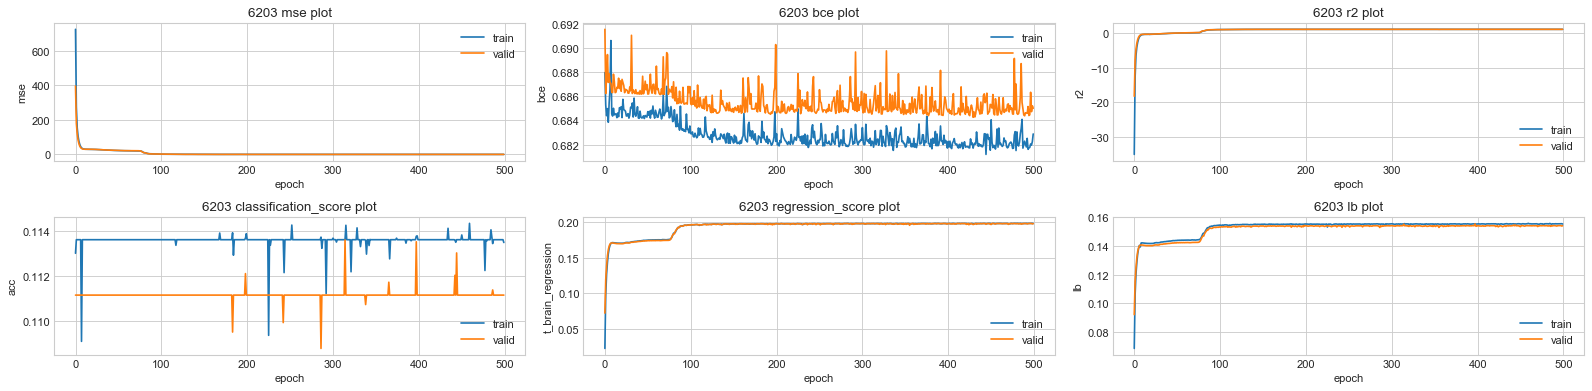

validation bce: 0.685010
validation mse: 0.307810
validation r2 : 0.985233
validation acc: 0.111154
validation regression: 0.197267
validation lb: 0.154211


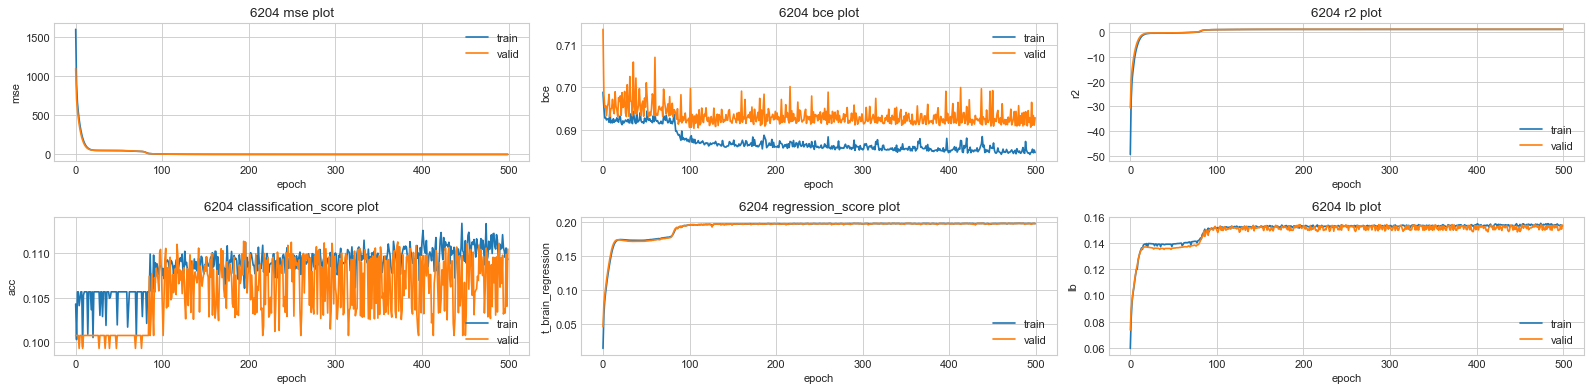

validation bce: 0.692846
validation mse: 0.628520
validation r2 : 0.981894
validation acc: 0.110500
validation regression: 0.197251
validation lb: 0.153876


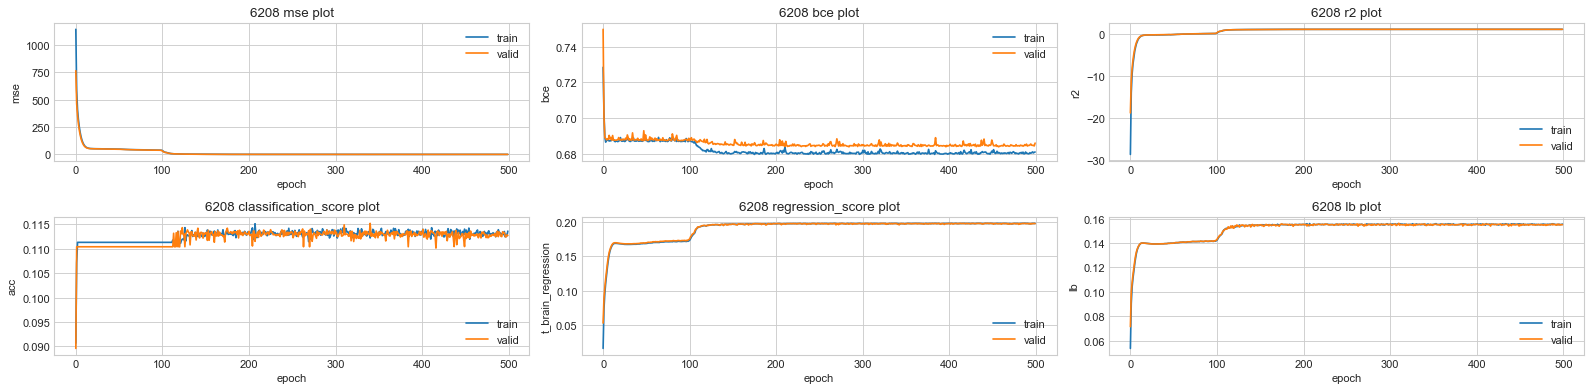

validation bce: 0.686045
validation mse: 0.556492
validation r2 : 0.985608
validation acc: 0.112731
validation regression: 0.197104
validation lb: 0.154917


In [11]:
from keras.callbacks import *
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64
EPOCH = 500
for model_n, (X, Y, label) in enumerate(train_18):
    X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(X, Y, label, test_size=0.2)
    prefix = str(codes[model_n])
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss={'regression':'mean_squared_error', 'class':'binary_crossentropy'}, optimizer='adam', metrics = {'regression':[r2_keras, regression_score], 'class':[classification_score]}, loss_weights={'class':2, 'regression':1})
    history = model.fit(X_train, [Y_train, label_train], validation_data=(X_test, [Y_test, label_test]) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'_logs')], shuffle=True, verbose=0)
    vis(history, title=prefix, dpi=180)
    print('validation bce: {:.6f}'.format(history.history['val_class_loss'][-1]))
    print('validation mse: {:.6f}'.format(history.history['val_regression_loss'][-1]))
    print('validation r2 : {:.6f}'.format(history.history['val_regression_r2_keras'][-1]))
    print('validation acc: {:.6f}'.format(history.history['val_class_classification_score'][-1]))
    print('validation regression: {:.6f}'.format(history.history['val_regression_regression_score'][-1]))
    print('validation lb: {:.6f}'.format(0.5*history.history['val_regression_regression_score'][-1]+0.5*history.history['val_class_classification_score'][-1]))
    model.save(prefix+'_model.h5')
    K.clear_session()

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
